# Compound Fitting with `SAMMY`

This Jupyter Notebook cell demonstrates the application of the `SAMMY` tool for fitting spectral transmission data using the `pleiades` utilities.

The transmission data utilized in this analysis originates from the [RPI measurement](https://doi.org/10.1016/j.anucene.2014.01.041) of enriched samples of [Eu-nat](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?subID=14382008) and [Eu-153](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?subID=14382007), which are documented on [EXFOR](https://www-nds.iaea.org/index-meeting-crp/CM-RF-2013/).

Europium comprises two stable isotopes, Eu-151 and Eu-153, with natural abundances of 47.8% and 52.2%, respectively. This example focuses on determining the abundances of these isotopes in both natural and enriched samples solely based on fitting the resonance transmission spectrum.

The analysis involves two main steps:

1. **Individual Isotope Fitting:** SAMMY is executed separately for each isotope. A simple configuration file is used to generate the resonance parameter file (.par file) employing resonance data directly sourced from ENDF8.

2. **Compound Isotopic Fitting:** The resonance spectra of both isotopes are combined to form an isotopic compound. SAMMY is then run again to fit the resonance spectrum and determine the most probable abundances of the isotopes.

In [23]:
%matplotlib inline
import pandas

# add pleiades to PYTHONPATH
import sys
sys.path.append("/sammy/Pleiades")

# add sammy to PATH
import os
os.environ["PATH"] += os.pathsep + "/sammy/sammy/build/bin"

## Configuration File for a Single Isotope

In this section, we provide an overview of the essential parameters within the configuration file. The configuration file is structured according to SAMMY conventions and contains vital information for the conversion process. Below, we focus on the key parameters relevant to this example:

- **ELMNT:** Specifies the element's name, denoted as 'Eu_151'. This identifier is crucial for SAMMY to recognize the isotope.

- **AW:** Is the isotopic mass. If `pleiades` identifies the `ELMNT` name, it automatically retrieves the mass from the AME database. Therefore, this parameter can be  set as 'auto'.

- **EMIN, EMAX:** Define the energy range for the analysis, indicating the minimum and maximum energies considered.

- **Commands:** This section includes essential commands for the configuration and generation of the `.par` file. Of particular importance is the 'INPUT IS ENDF/B FILE' command, instructing SAMMY to locate the reference to resonance data in the ENDF file. A MAT number will be replaced during subsequent steps, based on the isotope name.

- **Fit Parameters:** Defines crucial parameters for the fitting process:
  - `TEMP:` Represents the temperature in Kelvin.
  - `DIST:` Signifies the TOF (Time of Flight) distance in meters.
  - `CRFN:` Indicates the channel radius (not crucial at this stage).
  - `THICK:` Denotes the target thickness in units of atoms/barn.
  - `CROSS:` Specifies the reaction type, set here to 'TRANSMISSION.'

[comment]: # (- **Spin Groups:** This section is optional for this step. Here, two spin groups for the isotopes are specified. SAMMY automatically extracts this data from ENDF.)

Below is an example of the configuration file structure:

```ini
[Card1]
TITLE = input to convert ENDF8 file into a SAMMY par file

[Card2]
ELMNT = Eu-151
AW = auto
EMIN = 0.001
EMAX = 98.8

[Card3]
commands = CHI_SQUARED,CSISRS,NO_SOLVE_BAYES,USE_ENDF_ENERGY,INPUT IS ENDF/B FILE

[Card5]
TEMP = 296.
DIST = 25.584

[Card7]
CRFN = 1.0
THICK = 0.0021

[Card8]
CROSS = TRANSMISSION 


we save this file as `config_Eu_151.ini` and use `pleiades` to parse the file

In [24]:

from pleiades import sammyInput

# read config files and write inp files
saminp = sammyInput.InputFile("config_Eu_151.ini").process().write("Eu_151.inp")

# update the element name to Eu_153 and write a new file. 
# The matnumber and atomic weight are updates automaically
saminp.data["Card2"]["elmnt"] = "Eu-153"
saminp.data["Card2"]["aw"] = "auto"
saminp.process().write("Eu_153.inp")


In [25]:
!cat Eu_151.inp

input to convert ENDF8 file into a SAMMY par file                               
Eu-151      150.9199    0.0010   98.8000
CHI SQUARED IS WANTEd
CSISRS
DO NOT SOLVE BAYES EQUATIONS
QUANTUM NUMBERS ARE in parameter file
USE ENERGY RANGE FROm endf/b file
INPUT IS ENDF/B FILE MAT=6325

  296.0000   25.5840
    1.0000    0.0021
TRANSMISSION                                                                    



check the content of .inp files produced

In [26]:
!cat Eu_153.inp

input to convert ENDF8 file into a SAMMY par file                               
Eu-153      152.9212    0.0010   98.8000
CHI SQUARED IS WANTEd
CSISRS
DO NOT SOLVE BAYES EQUATIONS
QUANTUM NUMBERS ARE in parameter file
USE ENERGY RANGE FROm endf/b file
INPUT IS ENDF/B FILE MAT=6331

  296.0000   25.5840
    1.0000    0.0021
TRANSMISSION                                                                    



## Run SAMMY with ENDF data to produce .par file
For this step we use the `pleiades.sammyRunner` utility function `run_endf` which takes the inp files we have just created and run sammy to produce a par files using data from ENDF resonance tables.
The data is stored under separate directories at the `archive` directory

In [27]:
from pleiades import sammyRunner

sammyRunner.run_endf(inpfile="Eu_151.inp")
sammyRunner.run_endf(inpfile="Eu_153.inp")

Check that the par files were indeed created

In [28]:
ls archive/*/results

archive/Eu_151/results:
Eu_151.inp  Eu_151.lpt  Eu_151.par

archive/Eu_153/results:
Eu_153.inp  Eu_153.lpt  Eu_153.par

archive/Eu_nat/results:
Eu_nat.io  Eu_nat.lpt  Eu_nat.lst  Eu_nat.par


## Combine isotopic files into a compound
Now we want to take the two separate `.inp` and `.par` files that were created for each isotope of europium and create a compound that contains these two isotopes.

For this we will use the `pleiades.sammyParFile` utilities to create a `ParFile` object for each of the isotopes, combine it into one compound and write a new file that we can later run through `SAMMY`

For this example, we will set an equal weight (isotopic abundence) of 0.5 to each of the isotopes, and let `SAMMY` later deduce the correct weight according to fit over real data

In [66]:
from pleiades import sammyParFile

Eu_151 = sammyParFile.ParFile("archive/Eu_151/results/Eu_151.par",weight=0.5).read()
Eu_153 = sammyParFile.ParFile("archive/Eu_153/results/Eu_153.par",weight=0.5).read()

Now we form a compound by adding the two isotopes. `pleiades` will combine the resonance data from each isotope and create a new ParFile object that has all the neccasary data.

Then we use the `write` method to write the new `.par` into file.

In [67]:
# create compound
Eu_nat = Eu_151 + Eu_153

# set all resonance parameters to "vary"
# Eu_nat.update.toggle_vary_all_resonances(True)

# write to file
Eu_nat.write("Eu_nat.par")

Let's check the content of this par file. 

Notice that the resonance parameters are all vary, and also the abundances are set to **vary**. This is the default behaviour, later on, we will check what hapens when we vary different parameter, and check the effect of that change on the fit results

In [68]:
!cat Eu_nat.par

PARTICLE PAIR DEFINITIONS
Name=Eu_151       Particle a=neutron       Particle b=Other   
     Za= 0        Zb=63         Pent=1     Shift=0
     Sa=  0.5     Sb=   2.5     Ma=   1.008664915780000     Mb= 150.916445000000010
Name=Eu_153       Particle a=neutron       Particle b=Other   
     Za= 0        Zb=63         Pent=1     Shift=0
     Sa=  0.5     Sb=   2.5     Ma=   1.008664915780000     Mb= 152.921671000000003
 
SPIN GROUP INFORMATION
  1      1    0  2.0 0.5000000                                                  
    1  Eu_151      0         2            7.90000000 7.34863269                 
  2      1    0  3.0 0.5000000                                                  
    1  Eu_151      0         3            7.90000000 7.34863269                 
  3      1    0  2.0 0.5000000                                                  
    1  Eu_153      0         2            8.20000000 7.37750905                 
  4      1    0  3.0 0.5000000                                     

To run SAMMY on that new `.par` file we will need an `.inp` file as well. For that we can use the same `InpFile` object that we created for the `Eu_153` and just change the data a little bit

In [69]:
saminp.data

{'Card1': {'title': 'Run SAMMY to find abundence of europium isotopes'},
 'Card2': {'elmnt': 'Eu_nat', 'aw': 151.96, 'emin': '0.001', 'emax': 20},
 'Card3': {'commands': 'CHI_SQUARED,CSISRS,SOLVE_BAYES,QUANTUM_NUMBERS,REICH_MOORE_FORM,GENERATE ODF FILE AUTOMATICALLY,RPI TRANSMISSION RESOLUTION FUNCTION'},
 'Card5': {'temp': '296.', 'dist': '25.584', 'deltal': 0.0055},
 'Card7': {'crfn': '1.0', 'thick': 0.0021},
 'Card8': {'cross': 'TRANSMISSION'}}

In [70]:
# update a title
saminp.data["Card1"]["title"] = "Run SAMMY to find abundence of europium isotopes"

# update compound name and assumed atomic weight
saminp.data["Card2"]["elmnt"] = "Eu_nat"
saminp.data["Card2"]["aw"] = 151.96
saminp.data["Card2"]["emax"] = 20

# set the resolution width from flight path according to the RPI paper
saminp.data["Card5"]["deltal"] = 0.0055

# update commands. We need to preform the REICH_MOORE and SOLVE_BAYES for this case
saminp.data["Card3"]["commands"] = 'CHI_SQUARED,CSISRS,SOLVE_BAYES,QUANTUM_NUMBERS,REICH_MOORE_FORM,GENERATE ODF FILE AUTOMATICALLY,RPI TRANSMISSION RESOLUTION FUNCTION'

saminp.data["Card7"]["thick"] = 0.0021 # atoms/barn


Now process the data and write into file. Notice that this time we set ```auto_update=False```, since we don't want to replace "auto" values this time

In [71]:
# write the new input to file
saminp.process(auto_update=False).write("Eu_nat.inp")

## Run `SAMMY` with natural abundance data from RPI
We will use the `run` method from `sammyRunner` to run the fit. All our files have the same initial, `Eu_nat` so we can run by simply specifing the archive name as `Eu_nat`

In [72]:
ls Eu_nat*

Eu_nat.dat  Eu_nat.inp  Eu_nat.par


In [73]:
sammyRunner.run(archivename="Eu_nat")

Check the results using the `sammyOutput` utils

In [74]:
from pleiades import sammyOutput

lpt = sammyOutput.LptFile("archive/Eu_nat/results/Eu_nat.lpt")

# register two new search patterns
lpt.register_new_stats(keyname="weight_151",start_text="  Isotopic abundance",skipped_rows=2,line_format="float(line.split()[1])")
lpt.register_new_stats(keyname="weight_153",start_text="  Isotopic abundance",skipped_rows=3,line_format="float(line.split()[1])")

stats = lpt.stats()

# renormalize weights
total_weight = stats["weight_151"] + stats["weight_153"]
stats["weight_151"] /= total_weight
stats["weight_153"] /= total_weight

stats

{'input_file': 'Eu_nat.inp',
 'par_file': 'Eu_nat.par',
 'Emin': 0.001,
 'Emax': 20.0,
 'thickness': 0.0021,
 'varied_params': 2,
 'reduced_chi2': 3.4061,
 'weight_151': 0.46831608179752593,
 'weight_153': 0.5316839182024742}

The results are not very different from the natural abundance or europium as we would expect


In [79]:
import pandas 
stats_df = pandas.DataFrame(stats,index=["Eu_nat fit all res vary"])
stats_df["real_weight_151"] = 0.4781
stats_df["real_weight_153"] = 0.5219

stats_df["δw_151"] = (stats_df["weight_151"] - stats_df["real_weight_151"])/stats_df["real_weight_151"]*100
stats_df["δw_153"] = (stats_df["weight_153"] - stats_df["real_weight_153"])/stats_df["real_weight_153"]*100

stats_df.T

,Eu_nat fit all res vary
input_file,Eu_nat.inp
par_file,Eu_nat.par
Emin,0.001
Emax,20
thickness,0.0021
varied_params,2
reduced_chi2,3.4061
weight_151,0.468316
weight_153,0.531684
real_weight_151,0.4781


In [76]:
df = pandas.read_csv("archive/Eu_nat/results/Eu_nat.lst",
                     delim_whitespace=True,header=None,
                    names=["energy","xs_data","xs_data_err","xs_initial","xs_final",
                           "trans_data","trans_data_err","trans_initial","trans_final"])

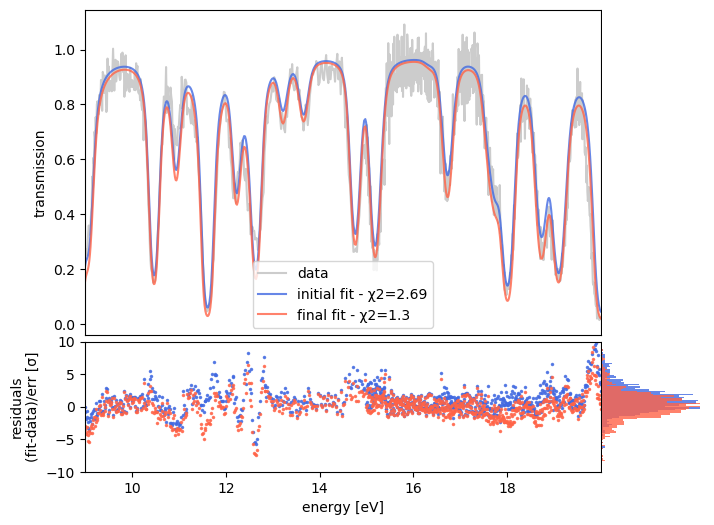

In [78]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2,2, sharey=False,
                        figsize=(8,6),
                        gridspec_kw={"width_ratios":[5,1],
                                     "height_ratios":[5,2]})
ax = np.ravel(ax)   

df.plot(x="energy",y="trans_data",
        ax=ax[0],
        colors=["0.8"],zorder=-1)
df.plot(x="energy",y=["trans_initial","trans_final"],
        ax=ax[0],
        colors=["royalblue","tomato"],alpha=0.8)
ax[0].set_xlabel("")
ax[0].set_xticks([])
ax[0].legend(["data","initial fit - χ2=2.69","final fit - χ2=1.3"])
ax[0].set_ylabel("")
ax[0].set_ylabel("transmission")
# ax[0].set_title("fit Eu-153 data from RPI using SAMMY8.1 with ENDF8")

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].set_xticks([])
ax[1].set_yticks([],[])


df["residual_initial"] = (df["trans_initial"] - df["trans_data"])/df["trans_data_err"]
df["residual_final"] = (df["trans_final"] - df["trans_data"])/df["trans_data_err"]
df.plot(x="energy",y=["residual_initial","residual_final"],marker=".",
        lw=0,ms=3,ylim=(-10,10),ax=ax[2],
        alpha=0.8,colors=["royalblue","tomato"],legend=False)
ax[2].set_ylabel("residuals\n(fit-data)/err [σ]")
# ax[2].legend(["initial fit","final fit"],loc=2,frameon=True)
ax[2].set_xlabel("energy [eV]")
# ax[2].set_xlim(0,100)

df.plot.hist(y=["residual_initial","residual_final"],bins=np.arange(-8,8,0.2),
            ax=ax[3],orientation="horizontal",
            legend=False,alpha=0.8,
            histtype="stepfilled",colors=["royalblue","tomato"])
ax[3].set_xlabel("")
ax[3].set_xticks([],[])
ax[3].set_yticks([],[])
ax[3].spines['right'].set_visible(False)
ax[3].spines['top'].set_visible(False)
ax[3].spines['bottom'].set_visible(False)
ax[3].spines['left'].set_visible(False)
ax[2].set_ylim(-10,10)
# df.plot.hist(y=["res_initial","residual"],bins=arange(-8,8,0.2),
#             ax=ax[1],orientation="horizontal",
#             histtype="step",legend=False,)
plt.subplots_adjust(wspace=0.003,hspace=0.03)


## Enriched sample data
We also have an enriched sample data, in that RPI experiment. Let's try to let SAMMY find the right abundence composition of that sample

In [81]:
sammyRunner.run(archivename="Eu_enriched",inpfile="Eu_nat.inp",parfile="Eu_nat.par",datafile="Eu_153.dat")

In [85]:
from pleiades import sammyOutput

lpt = sammyOutput.LptFile("archive/Eu_enriched/results/Eu_enriched.lpt")

# register two new search patterns
lpt.register_new_stats(keyname="weight_151",start_text="  Isotopic abundance",skipped_rows=2,line_format="float(line.split()[1].replace('(',''))")
lpt.register_new_stats(keyname="weight_153",start_text="  Isotopic abundance",skipped_rows=3,line_format="float(line.split()[1].replace('(',''))")

stats = lpt.stats()

# renormalize weights
total_weight = abs(stats["weight_151"]) + abs(stats["weight_153"])
stats["weight_151"] /= total_weight
stats["weight_153"] /= total_weight

stats

{'input_file': 'Eu_enriched.inp',
 'par_file': 'Eu_enriched.par',
 'Emin': 0.001,
 'Emax': 20.0,
 'thickness': 0.0021,
 'varied_params': 2,
 'reduced_chi2': 2.74594,
 'weight_151': -0.1319109611057538,
 'weight_153': 0.8680890388942463}